In [1]:
import sys
sys.path.append('/home/jhernandez/Work/')
sys.path.append('/home/jhernandez/Work/python_tools//')

from defaults import *

import pyroms

import seawater as sw

# Analyze High Frquency inertial oscillations HFR

-  Analyze HFR time serie (U, V). Check inertial oscillations
- Filter signal at point to extract high (low) frequency
- Do the same with WMOP
- Check if sincronous HF

In [2]:
# Define Points
nx = 8
ny = 19

### Select Date (month) to analyze.  
## September 2014

In [3]:
date = datetime(2014,9,1)
date2 = datetime(2014,10,1)

### Get HFR data from Thredds

In [4]:
#date = datetime(2018,1,1)
file = F"http://thredds.socib.es/thredds/dodsC/hf_radar/hf_radar_ibiza-scb_codarssproc001/L1/{date.year}/dep0001_hf-radar-ibiza_scb-codarssproc001_L1_{date.strftime('%Y-%m')}.nc"
file2 = F"http://thredds.socib.es/thredds/dodsC/hf_radar/hf_radar_ibiza-scb_codarssproc001/L1/{date2.year}/dep0001_hf-radar-ibiza_scb-codarssproc001_L1_{date2.strftime('%Y-%m')}.nc"

In [5]:
ds_hfr_sep = xr.open_dataset(file)
ds_hfr_oct = xr.open_dataset(file2)

ds_hfr = xr.concat([ds_hfr_sep, ds_hfr_oct], dim='time')
ds_hfr = ds_hfr.sel(time=slice('2014-09-20','2014-10-20'))

In [6]:
#ds_hfr_sep.merge(ds_hfr_oct)

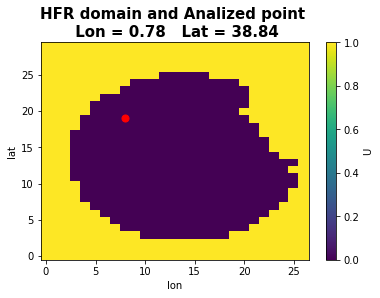

In [7]:
np.isnan(ds_hfr.U.mean(axis=0)).plot()
plt.scatter(nx, ny, 50, 'r')
plt.title(F"HFR domain and Analized point \n Lon = {ds_hfr.LON[nx].values:0.2f}   Lat = {ds_hfr.LAT[ny].values:0.2f}", fontsize=15, fontweight='bold')
plt.show()

In [8]:
u = ds_hfr.U.where((ds_hfr.QC_U==1) | (ds_hfr.QC_U==2)| (ds_hfr.QC_U==3))
v = ds_hfr.V.where((ds_hfr.QC_V==1) | (ds_hfr.QC_V==2)| (ds_hfr.QC_V==3))

In [9]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.values.nonzero()[0]

#### Extract U, V time Series at selected Point. Interpolate NaN values

In [10]:
u_unfilt = u[:,ny,nx]
nans, x = nan_helper(u_unfilt)
u_unfilt[nans]= np.interp(x(nans), x(~nans), u_unfilt[~nans])

v_unfilt = v[:,ny,nx]
v_unfilt[nans]= np.interp(x(nans), x(~nans), v_unfilt[~nans])
v_unfilt2 = v_unfilt[~np.isnan(v_unfilt)]


### Define Butterworth Filters

- fs = sampling frequncy. 1 hr for the case of HFR 
- cutoff. Normalized. 1/hours to filter. (E.g. 1/8 will filter signals with a period bigger than 8hrs for a low pass filter) 

In [11]:
import scipy.signal as sci_signal
from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = sci_signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sci_signal.filtfilt(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = sci_signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=4):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = sci_signal.filtfilt(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sci_signal.filtfilt(b, a, data)
    return y

#### Filter HFR Signals

In [12]:
# Filter U
u_filt_inert = butter_bandpass_filter(u_unfilt, 1/33, 1/8, 1, order=5)
u_filt_low = butter_lowpass_filter(u_unfilt, 1/33, 1, order=5)
u_filt_high = butter_highpass_filter(u_unfilt, 1/8, 1, order=5)

# Filter V
v_filt_inert = butter_bandpass_filter(v_unfilt, 1/33, 1/6, 1, order=5)
v_filt_low = butter_lowpass_filter(v_unfilt, 1/33, 1, order=5)
v_filt_high = butter_highpass_filter(v_unfilt, 1/8, 1, order=5)

### Plot Filtered HFR Signals

In [13]:
t_hfr = ds_hfr.time

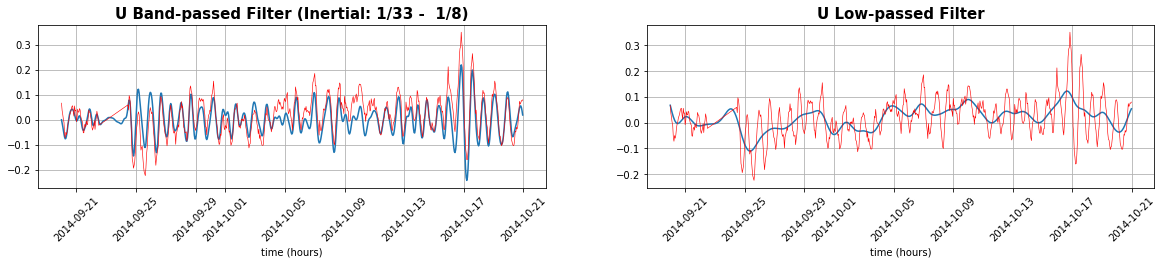

In [14]:
fig = plt.figure(figsize=(20,3))

plt.subplot(121)
plt.plot(t_hfr, u_filt_inert)
plt.plot(t_hfr, u_unfilt, 'r', linewidth=0.6)
plt.grid()
plt.xlabel('time (hours)')
plt.xticks(rotation=45)
plt.title('U Band-passed Filter (Inertial: 1/33 -  1/8)', fontsize=15, fontweight='bold')

#plt.figure(figsize=(12,4))
plt.subplot(122)
plt.plot(t_hfr, u_filt_low)
plt.plot(t_hfr, u_unfilt, 'r', linewidth=0.6)
plt.grid()
plt.xlabel('time (hours)')
plt.xticks(rotation=45)
plt.title('U Low-passed Filter', fontsize=15, fontweight='bold')

plt.show()

#fig.savefig('/home/jhernandez/Plots/HFR_inertial_oscillations_analysis/filtered_signal_hfr_u-component.png', dpi=250)

In [15]:
fig = plt.figure(figsize=(20,3))

plt.subplot(121)
#plt.plot(v_filt_high)
plt.plot(t_hfr, v_filt_inert)#,'k', linewidth=0.6)
plt.plot(t_hfr, v_unfilt, 'r', linewidth=0.6)
plt.grid()
plt.xlabel('time (hours)')
plt.xticks(rotation=45)
plt.title('V Band-passed Filter (Inertial: 1/33 -  1/8)', fontsize=15, fontweight='bold')

plt.subplot(122)
plt.plot(t_hfr, v_filt_low)
plt.plot(t_hfr, v_unfilt, 'r', linewidth=0.6)
plt.grid()
plt.xlabel('time (hours)')
plt.xticks(rotation=45)
plt.title('V Low-passed Filter', fontsize=15, fontweight='bold')

plt.show()

#fig.savefig('/home/jhernandez/Plots/HFR_inertial_oscillations_analysis/filtered_signal_hfr_v-component.png', dpi=250)

## Load WMOP fields For HFR DA experiment

- Get Free Run experiment his files
- Period: **2014/09/25**  -   **2014/09/29**

In [16]:
def get_dataset_period(date):
    
    #base_remote_wmop_surface = '/home/modelling/data/WMOP/WMOP_FORECAST/Outputs/FORECAST_ASSIM/archive/'
    base_remote_wmop_surface = '/home/modelling/data/workdir_2/HFR_DA/HFR_NOASSIM_Oct2014/'
    
    #wmop_filelist = glob(F"{base_remote_wmop_surface}/{date.year}/{date.month:02}/*his*") 
    wmop_filelist = glob(F"{base_remote_wmop_surface}/*ASSIM_2*his.nc") 

    wmop_filelist.sort()#reverse=True)
    ds = xr.open_mfdataset( wmop_filelist, concat_dim='ocean_time')

    #_,index = np.unique(ds['ocean_time'], return_index=True)
    #ds = ds[['u','v']].isel(ocean_time=index)
        
    return ds

In [17]:
ds_wmop = get_dataset_period(date)
_,index = np.unique(ds_wmop['ocean_time'], return_index=True)


In [18]:
# Lon, lat of HFR point
lon_p = ds_hfr.LON[nx].values
lat_p = ds_hfr.LAT[ny].values

# Find nearest point in WMOP coordinates
nlon = np.argmin(np.abs(ds_wmop.lon_u[0,:].values - lon_p))
nlat = np.argmin(np.abs(ds_wmop.lat_u[:,0].values - lat_p))

# Extract WMOP timeserie at HFR point
u_wmop = ds_wmop.u[:,-1, nlat, nlon].values[index]
v_wmop = ds_wmop.v[:,-1, nlat, nlon].values[index]

t_wmop = ds_wmop.ocean_time[index]

### Filter WMOP signal

In [22]:
fs = 1 / float((t_wmop[1]-t_wmop[0])/3600/1e9)

# Filter U
u_wmop_filt_inert = butter_bandpass_filter(u_wmop, 1/33, 1/9, fs, order=5)
u_wmop_filt_low = butter_lowpass_filter(u_wmop, 1/33, fs, order=5)
u_wmop_filt_high = butter_highpass_filter(u_wmop, 1/9, fs, order=5)

# Filter V
v_wmop_filt_inert = butter_bandpass_filter(v_wmop, 1/33, 1/9, fs, order=5)
v_wmop_filt_low = butter_lowpass_filter(v_wmop, 1/33, fs, order=5)
v_wmop_filt_high = butter_highpass_filter(v_wmop, 1/9, fs, order=5)

In [23]:

fig = plt.figure(figsize=(20,3))

plt.subplot(121)
plt.plot(t_wmop, u_wmop_filt_inert)
plt.plot(t_wmop, u_wmop, 'r', linewidth=0.6)
plt.grid()
plt.xlabel('time (hours)')
plt.xticks(rotation=45)
plt.title('U WMOP Band-passed Filter (Inertial: 1/33 -  1/8)', fontsize=15, fontweight='bold')

plt.subplot(122)
plt.plot(t_wmop, u_wmop_filt_low)
plt.plot(t_wmop, u_wmop, 'r', linewidth=0.6)
plt.grid()
plt.xlabel('time (hours)')
plt.xticks(rotation=45)
plt.title('U WMOP Low-passed Filter', fontsize=15, fontweight='bold')

plt.show()

#fig.savefig('/home/jhernandez/Plots/HFR_inertial_oscillations_analysis/filtered_signal_wmop_u-component_TN.png', dpi=250)

In [24]:
#t = np.arange((u_wmop.shape[0]))*3

fig = plt.figure(figsize=(20,3))

plt.subplot(121)
plt.plot(t_wmop, v_wmop_filt_inert)
plt.plot(t_wmop, v_wmop, 'r', linewidth=0.6)
plt.grid()
plt.xlabel('time (hours)')
plt.xticks(rotation=45)
plt.title('V WMOP Band-passed Filter (Inertial: 1/33 -  1/8)', fontsize=15, fontweight='bold')

plt.subplot(122)
plt.plot(t_wmop, v_wmop_filt_low)
plt.plot(t_wmop, v_wmop, 'r', linewidth=0.6)
plt.grid()
plt.xlabel('time (hours)')
plt.xticks(rotation=45)
plt.title('V WMOP Low-passed Filter', fontsize=15, fontweight='bold')

plt.show()

#fig.savefig('/home/jhernandez/Plots/HFR_inertial_oscillations_analysis/filtered_signal_wmop_v-component_TN.png', dpi=250)

#### Print Mean Values

In [25]:
print(' U WMOP')
#print(F" High Pass mean = { np.mean(u_wmop_filt_high):.4f}")
print(F" Inertial  mean = { np.mean(u_wmop_filt_inert):.6f}")
print(F" Low Pass  mean = {np.mean(u_wmop_filt_low):.4f}")
print(F"           mean = {np.mean(u_wmop):.4f}")

print('\n V WMOP')
#print(F" High Pass mean = { np.mean(v_wmop_filt_high):.4f}")
print(F" Inertial  mean = { np.mean(v_wmop_filt_inert):.4f}")
print(F" Low Pass  mean = {  np.mean(v_wmop_filt_low):.4f}")
print(F"           mean = {np.mean(v_wmop):.4f}")

print('\n U HFR')
#print(F" High Pass mean = {np.mean(u_filt_high):.4f}")
print(F" Inertial  mean = { np.mean(u_filt_inert):.4f}")
print(F" Low Pass  mean = { np.mean(u_filt_low):.4f}")
print(F"           mean = {np.mean(u_unfilt.values):.4f}")

print('\n V HFR')
#print(F" High Pass  mean = { np.mean(v_filt_high):.4f}")
print(F" Inertial  mean = { np.mean(v_filt_inert):.4f}")
print(F" Low Pass  mean = { np.mean(v_filt_low):.4f}")
print(F"           mean = {np.mean(v_unfilt.values):.4f}")

 U WMOP
 Inertial  mean = -0.000024
 Low Pass  mean = 0.0519
           mean = 0.0518

 V WMOP
 Inertial  mean = 0.0011
 Low Pass  mean = 0.0289
           mean = 0.0300

 U HFR
 Inertial  mean = -0.0002
 Low Pass  mean = 0.0175
           mean = 0.0171

 V HFR
 Inertial  mean = 0.0003
 Low Pass  mean = -0.0591
           mean = -0.0587


## FFT analysis

##### Functions

In [26]:
from scipy.fftpack import fft

def get_fft_values(y_values, T):
    N = y_values.shape[0]
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    #f_values = np.arange((N//2))
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values


def plot_fft(f_values, fft_values, title=None, labels=None):
    
    fig = plt.figure(figsize=(16,4))

    ax = plt.subplot(111)
    
    if (isinstance(fft_values, list)):
        for i in range(len(fft_values)):
            plt.plot(f_values[i], fft_values[i], label=labels[i])
    else:
        plt.plot(f_values, fft_values, label=labels[0])
        
    plt.grid()
    ax.set_xlim((0,0.4))
    plt.xlabel('Frequency (1/hours)', fontsize=12)
    
    # Create secondary axis for Period label
    locs, labels = plt.xticks()
    ax2 = plt.twiny()
    ax2.set_xlim((0,0.4))

    lab2 = [np.round(1/l,3) for l in locs]
    plt.xticks(locs[1:], lab2[1:], color='k', fontsize=12)
    plt.xlabel('Period (hours)', color='k', fontsize=12)

    plt.title(title, fontsize=15, fontweight='bold')
    ax.legend()
    plt.show()
    
    return fig

#### Plot FFT U. HFR vs WMOP

In [27]:
u_filt3 = butter_bandpass_filter(u_unfilt, 1/22, 1/18, 1, order=5)
u_filt2 = butter_bandpass_filter(u_unfilt, 1/19, 1/16, 1, order=5)
f_u_filt3, fft_u_filt3 = get_fft_values(u_filt3,1)
f_u_filt2, fft_u_filt2 = get_fft_values(u_filt2,1)

# Make FFT of whole HFR and WMOP signals
f_u_hfr, fft_u_hfr = get_fft_values(u_unfilt,1)
f_u_wmop, fft_u_wmop = get_fft_values(u_wmop,4)


#plot_fft([f_u_hfr, f_u_filt3, f_u_filt2], [fft_u_hfr, fft_u_filt3, fft_u_filt2], title='FFT U-component', labels=['HFR', 'HFR filt', 'HFR filt2'])
fig = plot_fft([f_u_hfr, f_u_wmop], [fft_u_hfr, fft_u_wmop], title='FFT U-component', labels=['HFR', 'WMOP'])

#fig.savefig('/home/jhernandez/Plots/HFR_inertial_oscillations_analysis/fft_hfr-vs-wmop_u-component_TN.png', dpi=250)


#### Plot FFT V. HFR vs WMOP

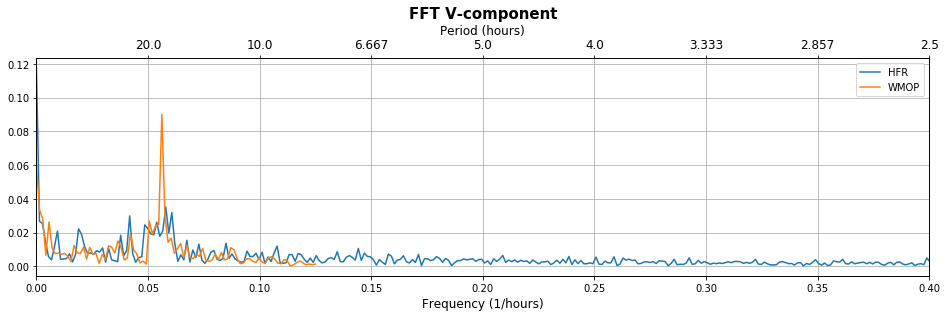

In [28]:
f_v_hfr, fft_v_hfr = get_fft_values(v_unfilt,1)
f_v_wmop, fft_v_wmop = get_fft_values(v_wmop,4)


fig = plot_fft([f_v_hfr, f_v_wmop], [fft_v_hfr, fft_v_wmop], title='FFT V-component', labels=['HFR', 'WMOP'])

#fig.savefig('/home/jhernandez/Plots/HFR_inertial_oscillations_analysis/fft_hfr-vs-wmop_v-component_TN.png', dpi=250)

### Plot WMOP and HFR together

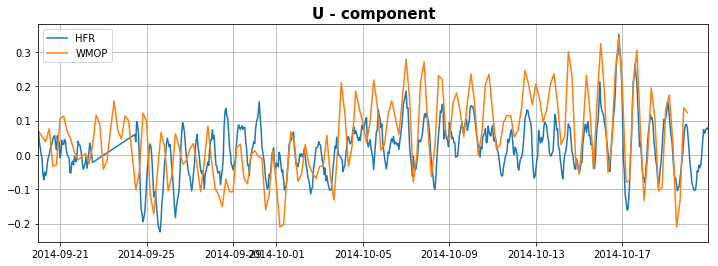

In [29]:
fig = plt.figure(figsize=(12,4))
plt.plot(t_hfr, u_unfilt.values, label='HFR')
plt.plot(t_wmop, u_wmop, label='WMOP')
plt.grid()
plt.legend()
plt.title('U - component', fontsize=15, fontweight='bold')
plt.xlim((np.min(t_hfr.values), np.max(t_hfr.values)))
plt.show()

#fig.savefig('/home/jhernandez/Plots/HFR_inertial_oscillations_analysis/hfr-vs-wmop_u-component_TN.png', dpi=250)

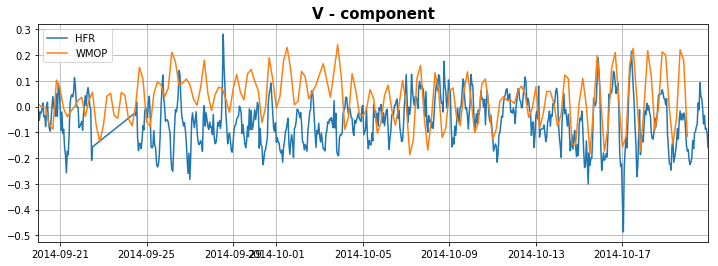

In [30]:
fig = plt.figure(figsize=(12,4))
plt.plot(t_hfr, v_unfilt.values, label='HFR')
plt.plot(t_wmop, v_wmop, label='WMOP')
plt.grid()
plt.legend()
plt.title('V - component', fontsize=15, fontweight='bold')
plt.xlim((np.min(t_hfr.values), np.max(t_hfr.values)))

plt.show()

#fig.savefig('/home/jhernandez/Plots/HFR_inertial_oscillations_analysis/hfr-vs-wmop_v-component_TN.png', dpi=250)

#### Check Cross-Correlation between U-V inertial oscillations

- Should have a pi/2 phase difference. This is around 5 hours for a tipical inertial period around 20 hours

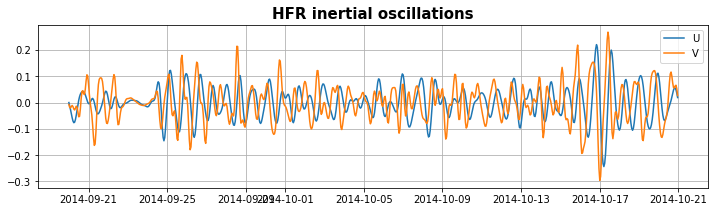

In [31]:
plt.figure(figsize=(12,3))

plt.plot(t_hfr, u_filt_inert, label='U')
plt.plot(t_hfr, v_filt_inert, label='V')
plt.grid()
plt.legend()
#plt.xlabel('time (hours)')
plt.title('HFR inertial oscillations', fontsize=15, fontweight='bold')

plt.show()

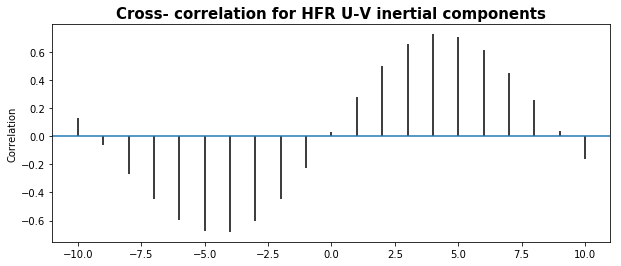

In [32]:
plt.figure(figsize=(10,4))

plt.xcorr(u_filt_inert, v_filt_inert)
plt.ylabel('Correlation')
plt.title('Cross- correlation for HFR U-V inertial components', fontsize=15, fontweight='bold')
plt.show()

#### Plot Velocity at selected Point. HFR vs WMOP 

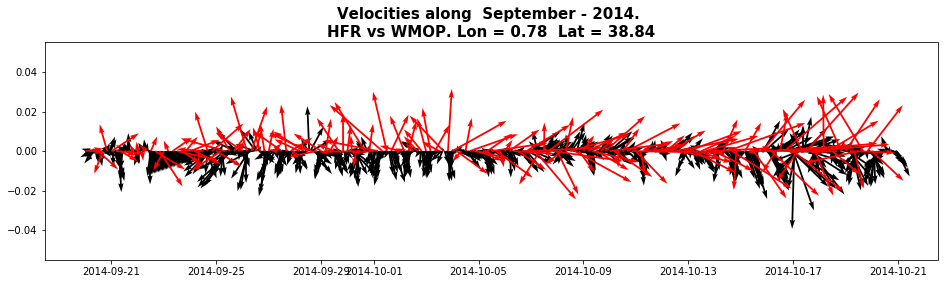

In [33]:
plt.figure(figsize=(16,4))
plt.quiver(t_hfr.values, np.zeros(t_hfr.values.shape), u_unfilt, v_unfilt, width=0.002)
plt.quiver(t_wmop.values, np.zeros(t_wmop.values.shape), u_wmop, v_wmop, width=0.002, color='r')
plt.title(F"Velocities along  {date.strftime('%B')} - {date.year}. \nHFR vs WMOP. Lon = {lon_p:0.2f}  Lat = {lat_p:0.2f}", fontsize=15, fontweight='bold')

plt.show()

### Wavelet

In [34]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pywt

def plot_spectrogram( fig, ax, signal, time, title=None, wavelet_name='morl'):
    
    delta_t = float((time[1] - time[0])/3600/1e9)
    scales = np.arange(1,128)
    
    [coefficients, frequencies] = pywt.cwt(signal, scales, wavelet_name, delta_t)

    period_of_reference=20
    cmap=plt.cm.Reds
    levels=[1, 2, 4, 8, 16, 32] 
    levels=[0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175]

    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    contourlevels = np.log2(levels)

    im = ax.contourf(time, period, power, extend='both', cmap=cmap)#, contourlevels=contourlevels)

    ax.hlines(period_of_reference, xmin=time[0], xmax=time[-1], color='black', label='Period of Reference')
    ax.hlines(33, xmin=time[0], xmax=time[-1], color='black', linestyle='--', linewidth=0.6, label='Period of Reference')
    ax.hlines(6, xmin=time[0], xmax=time[-1], color='black', linestyle='--', linewidth=0.6, label='Period of Reference')
#
    plt.ylim((0,120))
    plt.xticks(rotation=30)
    im.cmap.set_under('white')
    
    fig.colorbar(im,  ax=ax, orientation="vertical")
    plt.title(title, fontsize=15, fontweight='bold')
    plt.ylabel('Period (hours)')

#### U - HFR wavelet analysis

In [35]:
signals = {'U Unfiltered': u_unfilt.values, 'U Inertial': u_filt_inert, 'U Low': u_filt_low, 'U high': u_filt_high}
time = t_hfr.values

fig = plt.figure(figsize=(18,15))

for i, s in enumerate(signals):

    ax = plt.subplot(2,2,i+1)
    plot_spectrogram( fig, ax, signals[s], time, title=s + '  HFR')    



#### U - WMOP wavelet analysis

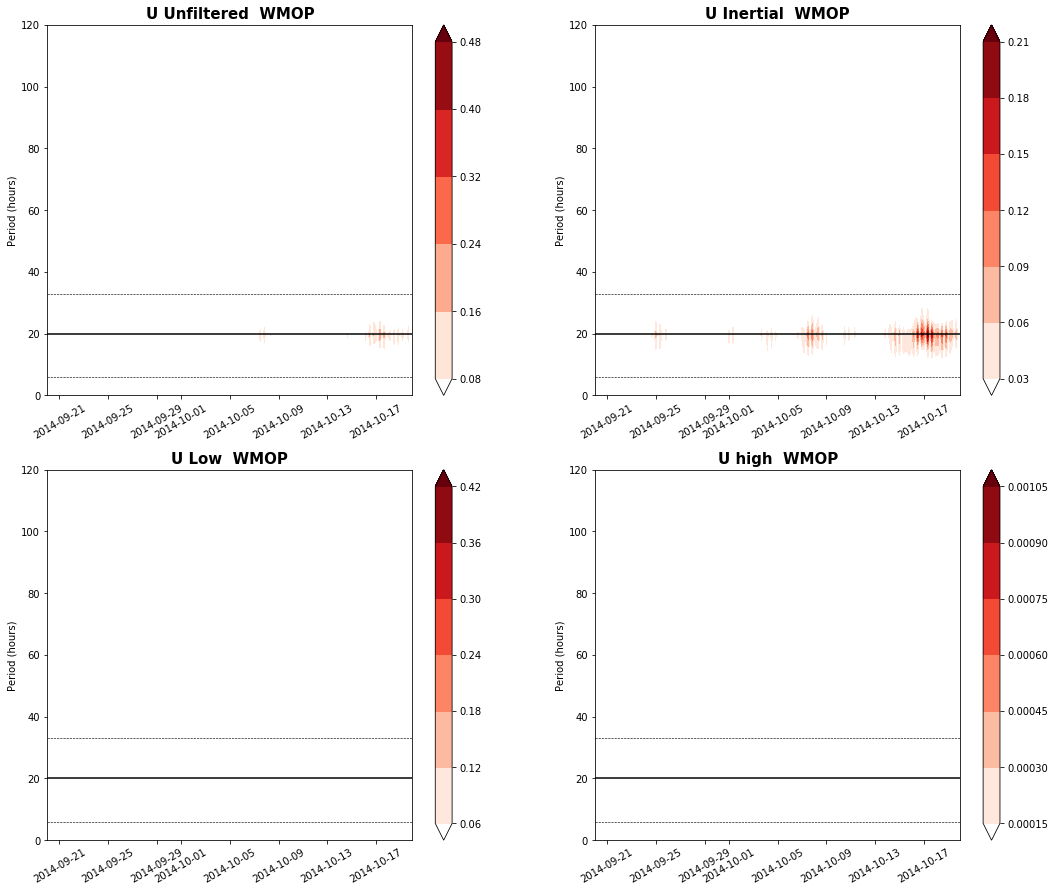

In [36]:
signals = {'U Unfiltered': u_wmop, 'U Inertial': u_wmop_filt_inert, 'U Low': u_wmop_filt_low, 'U high': u_wmop_filt_high}
time = t_wmop.values

fig = plt.figure(figsize=(18,15))

for i, s in enumerate(signals):

    ax = plt.subplot(2,2,i+1)
    plot_spectrogram( fig, ax, signals[s], time, title=s + '  WMOP')    



### Plot Inertial Oscillations for U, V components of HFR vs WMOP

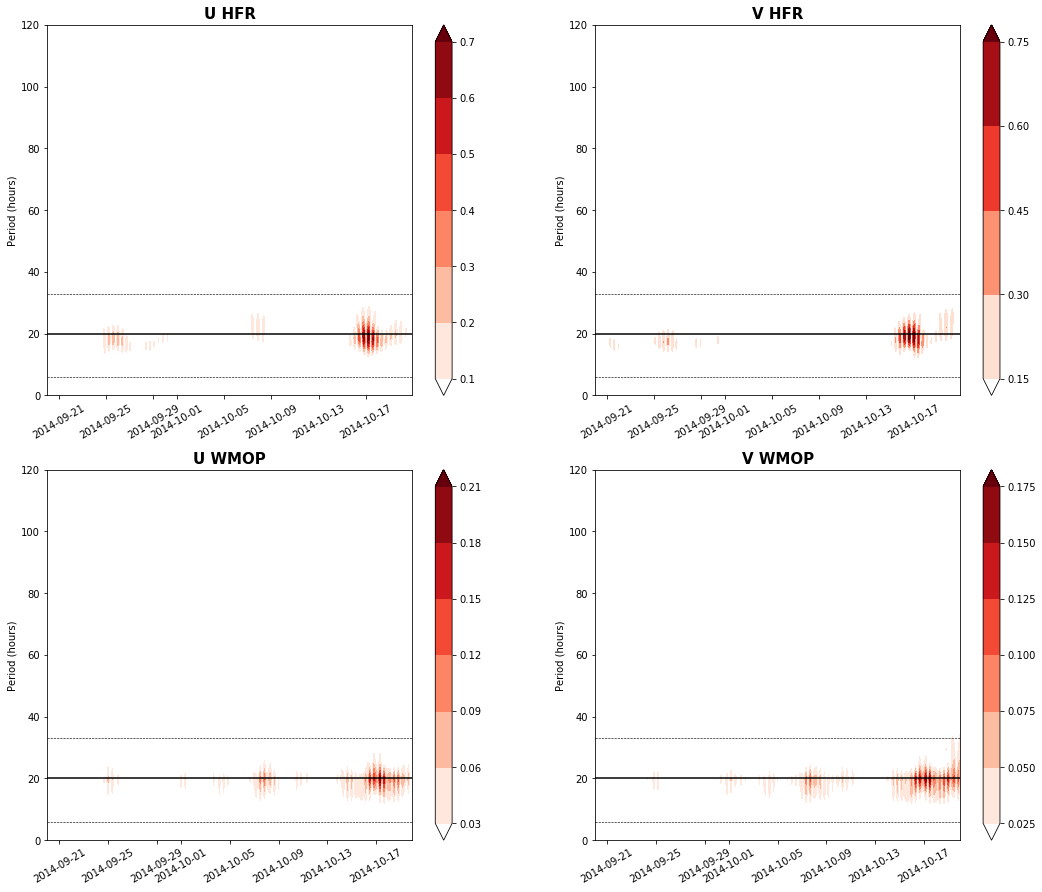

In [37]:
fig = plt.figure(figsize=(18,15))
signals = {'U HFR': [u_filt_inert, t_hfr.values],
           'V HFR': [v_filt_inert, t_hfr.values],
           'U WMOP': [u_wmop_filt_inert, t_wmop.values],
           'V WMOP': [v_wmop_filt_inert, t_wmop.values]}

for i, s in enumerate(signals):

    ax = plt.subplot(2,2,i+1)
    plot_spectrogram( fig, ax, signals[s][0], signals[s][1], title=s)
    
#fig.savefig('/home/jhernandez/Plots/HFR_inertial_oscillations_analysis/wavelet_spectrogram_inertial_band_TN.png', dpi=250)

#### Plot Inertial oscillations

In [39]:
fig = plt.figure(figsize=(15,4))
plt.plot(t_wmop, u_wmop_filt_inert, label='WMOP')
plt.plot(t_hfr, u_filt_inert, label='HFR')
plt.grid()
plt.title('U-components Inertial oscillations', fontsize=15, fontweight='bold')
plt.legend()

plt.show()

fig.savefig('/home/jhernandez/Plots/HFR_inertial_oscillations_analysis/inertial_oscillations_hfr-vs-wmop_u-component_TN.png', dpi=250)

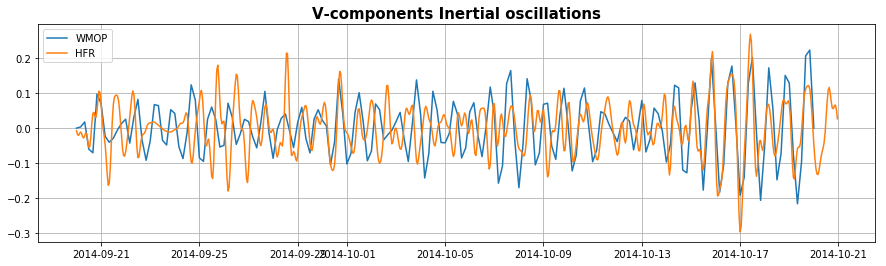

In [40]:
fig = plt.figure(figsize=(15,4))
plt.plot(t_wmop, v_wmop_filt_inert, label='WMOP')
plt.plot(t_hfr, v_filt_inert, label='HFR')
plt.grid()
plt.title('V-components Inertial oscillations', fontsize=15, fontweight='bold')
plt.legend()

plt.show()

fig.savefig('/home/jhernandez/Plots/HFR_inertial_oscillations_analysis/inertial_oscillations_hfr-vs-wmop_v-component_TN.png', dpi=250)

#### Resample WMOP signals to hourly data. 

- First we create pandas DataFrame separately for WMOP and HFR time series containing both U and V
- We resample to have exactly the same time period (hourly data)
- Keep obs for the same time period
- We calculate correlations between time series


In [41]:
# Create DataFrame with inertial oscillations
df_inert_hfr = pd.DataFrame(data={'u':u_filt_inert, 'v':v_filt_inert}, index=t_hfr.values)

# Create DataFrame with inertial oscillations
df_inert_wmop = pd.DataFrame(data={'u':u_wmop_filt_inert, 'v':v_wmop_filt_inert}, index=t_wmop.values)
df_inert_wmop = df_inert_wmop.resample('H').interpolate()
df_inert_wmop = df_inert_wmop[df_inert_wmop.index <= df_inert_hfr.index[-1]]



In [44]:
print(df_inert_hfr.shape)
print(df_inert_wmop.shape)

(744, 2)
(721, 2)


### Calcualte Cross-correlations

ValueError: x and y must be equal length

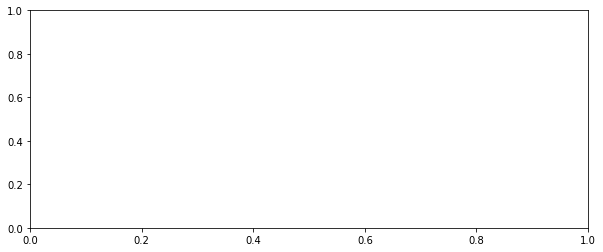

In [42]:
plt.figure(figsize=(10,4))
plt.xcorr( df_inert_wmop['u'], df_inert_hfr['u'])
plt.title('Cross-correlation Inertial oscillations U component', fontsize=15, fontweight='bold')
plt.show()

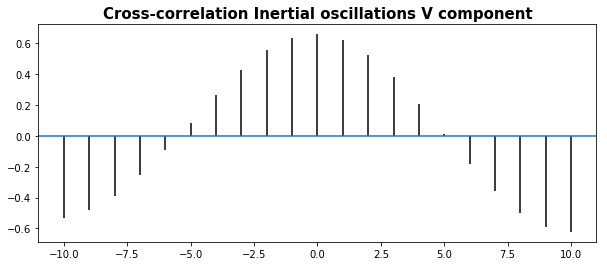

In [38]:
plt.figure(figsize=(10,4))
plt.xcorr( df_inert_wmop['v'], df_inert_hfr['v'])
plt.title('Cross-correlation Inertial oscillations V component', fontsize=15, fontweight='bold')
plt.show()